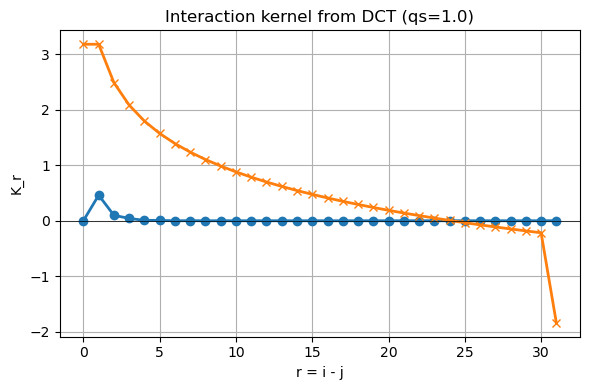

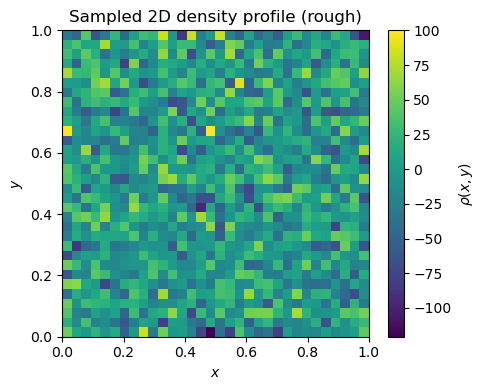

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy
import torch.fft as tfft
import pandas as pd
import torch_dct as dct
from numpy import size
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ewaldnn2d import *

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float64
device = "cpu"
N_batch = 100
N_epochs = 10000
lr = 1e-1 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 500    # epochs to wait for improvement before stopping training'
pad_mode = "reflect" # in this example, we use reflective padding for local feature generation
N_pow = 1 # number of local features per grid point
N_train = 1500
N_test = 250
N_val = 250

# grid and basis settings
N_x = 32 # number of grid points in x direction
N_y = N_x # number of grid points in y direction
m_x = torch.arange(0, N_x, dtype=dtype, device=device)             # (N_x,)
m_y = torch.arange(0, N_y, dtype=dtype, device=device)             # (N_y,)
abs_val = torch.sqrt(m_x[:, None]**2 + m_y[None, :]**2)  # (M_x, M_y)
x = torch.linspace(0, 1, N_x, dtype=dtype, device=device)            # (N_x,)
y = torch.linspace(0, 1, N_y, dtype=dtype, device=device)            # (N_y,)
DM_x = torch.cos(torch.pi * torch.outer(m_x, x))                  # (M_x, N_x)
DM_y = torch.cos(torch.pi * torch.outer(m_y, y))                  # (M_y, N_y)
DerDM_x = -torch.pi * m_x[:, None] * torch.sin(torch.pi * torch.outer(m_x, x))  # (M_x, N_x) # derivative of design matrix
DerDM_y = -torch.pi * m_y[:, None] * torch.sin(torch.pi * torch.outer(m_y, y))  # (M_y, N_y) # derivative of design matrix

data_regime = "rough" # "smooth" or "rough"
if data_regime == "smooth":
    M_cutoff = 10 # maximum harmonic   
    std_harm = 2.0 / (1.0 + 0.2 * abs_val)**2 * (abs_val <= M_cutoff).double()  # (M_x, M_y)
elif data_regime == "rough":
    std_harm = 2.0 / (1.0 + 0.0 * abs_val)**2 # (M_x, M_y)
else:
    raise ValueError("regime must be 'smooth' or 'rough'")
std_harm[0, 0] = 0.0 # no uniform density offset

# interaction kernel parameters
qs = 1.0 # screening momentum
amp = 1.0 # amplitude of interaction kernel
kernel_regime = "screened_coulomb"
def E_tot(rho: torch.Tensor, d_rho_x: torch.Tensor, d_rho_y: torch.Tensor) -> torch.Tensor:
        return amp * E_int_ms_dct(rho, kernel=kernel_regime, qs=qs)
    
# generate train/test split
flag_generate_data = True # if True, generate new data; if False, load existing data from disk
if flag_generate_data:
    N_batch_int = 10 # number of density profiles per data generation batch
    torch.manual_seed(1234) # for reproducibility
    rho_train, d_rho_x_train, d_rho_y_train, a_train, targets_train = generate_data_2d(N_train, N_batch_int, E_tot, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)
    rho_test, d_rho_x_test, d_rho_y_test, a_test, targets_test = generate_data_2d(N_test, N_batch_int, E_tot, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y) 
    rho_val, d_rho_x_val, d_rho_y_val, a_val, targets_val = generate_data_2d(N_val, N_batch_int, E_tot, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)  
    # save data to disk
    os.makedirs("DATA2d", exist_ok=True)

    fname = f"DATA2d/dataset_{data_regime}_{kernel_regime}_{qs}_{amp}_{N_x}_{N_y}.pt"

    torch.save(
        {
            "rho_train": rho_train,
            "d_rho_x_train": d_rho_x_train,
            "d_rho_y_train": d_rho_y_train,
            "a_train": a_train,
            "targets_train": targets_train,
            "rho_val": rho_val,
            "d_rho_x_val": d_rho_x_val,
            "d_rho_y_val": d_rho_y_val,
            "a_val": a_val,
            "targets_val": targets_val,
            "rho_test": rho_test,
            "d_rho_x_test": d_rho_x_test,
            "d_rho_y_test": d_rho_y_test,
            "a_test": a_test,
            "targets_test": targets_test,
            "data_regime": data_regime,
            "kernel_regime": kernel_regime,
        },
        fname,
    )
else:
    data = torch.load(f"DATA2d/dataset_{data_regime}_{kernel_regime}_{qs}_{amp}_{N_x}_{N_y}.pt")
    rho_train = data["rho_train"]
    targets_train = data["targets_train"]
    rho_test = data["rho_test"]
    targets_test = data["targets_test"]
    rho_val = data["rho_val"]
    targets_val = data["targets_val"]

features_train = generate_loc_features_rs(rho_train, N_pow=N_pow)  # (N_train, N_x, N_y, N_feat)
features_test  = generate_loc_features_rs(rho_test, N_pow=N_pow)   # (N_test, N_x, N_y, N_feat)
features_val   = generate_loc_features_rs(rho_val, N_pow=N_pow)    # (N_val, N_x, N_y, N_feat)

# Normalize features
mean_feat, std_feat = compute_normalization_stats(features_train)
features_train_norm = normalize_features(features_train, mean_feat, std_feat)
features_test_norm = normalize_features(features_test, mean_feat, std_feat)
features_val_norm = normalize_features(features_val, mean_feat, std_feat)

# Normalize targets
E_mean = targets_train.mean()
E_std = targets_train.std()
targets_train_norm = (targets_train - E_mean) / E_std
targets_test_norm = (targets_test - E_mean) / E_std
targets_val_norm = (targets_val - E_mean) / E_std

# Datasets
train_dataset = TensorDataset(features_train_norm, targets_train_norm)
val_dataset   = TensorDataset(features_val_norm,   targets_val_norm)
test_dataset  = TensorDataset(features_test_norm,  targets_test_norm)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)


# --- visualize the interaction kernel ---
m_vals = torch.arange(0, N_x, device=device, dtype=dtype)
n_vals = torch.arange(0, N_y, device=device, dtype=dtype)
q_x = torch.pi * m_vals.view(-1, 1) / (N_x - 1)
q_y = torch.pi * n_vals.view(1, -1) / (N_y - 1)
q_vals = torch.sqrt(q_x**2 + q_y**2)  # (N_x, N_y)
lam_K =  amp * Lam_K_Coulomb(q_vals, qs=qs)
K = kernel_from_eigenvals_dct(lam_K)

x_vals = torch.arange(0, N_x, device=device, dtype=dtype).view(-1, 1)   # (N_x, 1)
y_vals = torch.arange(0, N_y, device=device, dtype=dtype).view(1, -1)   # (1, N_y)
r_vals = torch.sqrt(x_vals**2 + y_vals**2)  # (N_x, N_y)

K_log_r = - torch.log(r_vals)  # K_r = -log(r) 
K_log_r[0, 0] = 0.0  # define K_0 = 0
Lam_K_log_r = kernel_eigenvals_dct(K_log_r) 
Lam_K_log_r[0, 0] = 0.0 # avoid division by zero
K_log_r = amp * kernel_from_eigenvals_dct(Lam_K_log_r)

plt.figure(figsize=(6,4))
plt.plot(x_vals, K[:, 0], 'o-', linewidth=2, label="From DCT")
plt.plot(x_vals, K_log_r[:, 0], 'x-', linewidth=2, label="True")
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.title(f"Interaction kernel from DCT (qs={qs})")
plt.grid(True)
plt.tight_layout()
plt.show()

# visualize a sampled density profile
rho_batch, _, _ , a_batch = sample_density_batch(N_batch, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y) 
rho_np = rho_batch[0, :, :].detach().cpu().numpy()
plt.figure(figsize=(5, 4))
im = plt.imshow(
    rho_np.T,              # transpose so x is horizontal, y vertical
    origin="lower",
    extent=[0, 1, 0, 1],   # x from 0 to 1, y from 0 to 1
    aspect="equal"
)
plt.colorbar(im, label=r"$\rho(x,y)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
if data_regime == "rough":
    plt.title("Sampled 2D density profile (rough)")
elif data_regime == "smooth":
    plt.title("Sampled 2D density profile (smooth)")
plt.tight_layout()
plt.show()

In [2]:
ckpt_dir = "LearningSC2d_checkpoints"
flag_train = False  # set to True to train models
learning_regime = "dct_coulomb"

run_name = f"rs_dct_kernel_" + data_regime + '_' + kernel_regime + f"_{qs}_{amp}_{N_x}_{N_y}"

if flag_train:
    torch.manual_seed(1234) # for reproducibility    
    model = DCTKernelEnergyNN(
            N_x=N_x,
            N_y=N_y,
            learning_mode="dct_coulomb",
            mean_feat=mean_feat,
            std_feat=std_feat,
            E_mean=E_mean,
            E_std=E_std,
        ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Reduce LR when val loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=50, cooldown=2, min_lr=1e-6
    )

    hist, best_epoch = train_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        max_epochs=N_epochs,
        patience=patience,
        min_delta=min_delta,
        ckpt_dir=ckpt_dir,
        run_name=run_name,
        learning_regime=learning_regime,
        N_x=N_x,
        N_y=N_y,
        device=device,
    )

   epoch  train_loss  val_loss
0      1    0.333602  0.003065
1      2    0.024283  0.006281
2      3    0.009590  0.007099
3      4    0.002840  0.000813
4      5    0.000671  0.000182


<Axes: title={'center': 'rs_dct_kernel_rough_screened_coulomb_1.0_1.0_32_32'}, xlabel='epoch'>

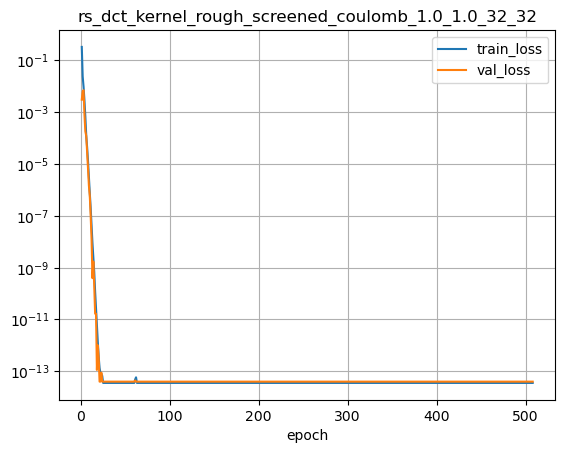

In [3]:
path = ckpt_dir + f"/{run_name}_history.csv"
hist_df = pd.read_csv(path)
print(hist_df.head())
hist_df.plot(x="epoch", y=["train_loss", "val_loss"], logy=True, grid=True, title=run_name)

Learned Screened Coulomb Kernel:
Amplitude: Parameter containing:
tensor([0.9997], requires_grad=True)
q_s: tensor(0.9986)


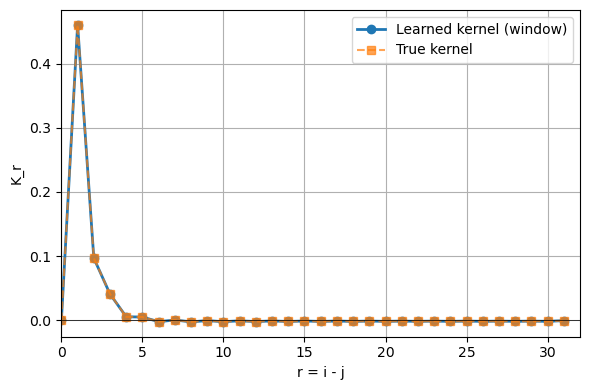

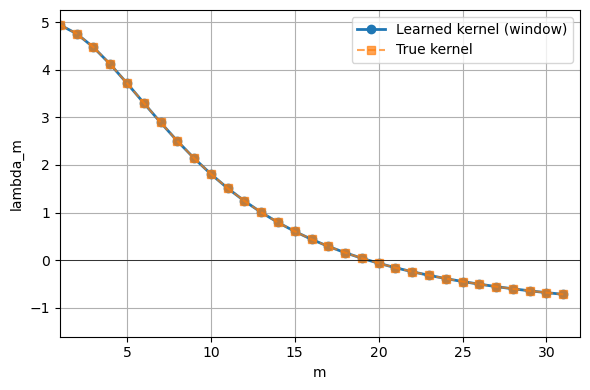

In [8]:
model, normalization, epoch, val_loss = load_checkpoint(
        ckpt_dir + f"/{run_name}_best.pt",
        DCTKernelEnergyNN,
        device=device
    )

print("Learned Screened Coulomb Kernel:")
with torch.no_grad():
    qs = F.softplus(model.nonlocal_kernel.raw_qs)
    amp = model.nonlocal_kernel.amp
    print("Amplitude:", amp)
    print("q_s:", qs)
    lam_K_full = (amp * Lam_K_Coulomb(model.nonlocal_kernel.q_vals, qs=qs)).to(device=device, dtype=dtype)  # (N_x, N_y)
    k_full = kernel_from_eigenvals_dct(lam_K_full)


# visualize the interaction kernel
m_vals = torch.arange(0, N_x, device=device, dtype=dtype)
n_vals = torch.arange(0, N_y, device=device, dtype=dtype)
q_x = torch.pi * m_vals.view(-1, 1) / (N_x - 1)
q_y = torch.pi * n_vals.view(1, -1) / (N_y - 1)
q_vals = torch.sqrt(q_x**2 + q_y**2)  # (N_x, N_y)
lam_K = Lam_K_Coulomb(q_vals, qs=qs)
k_true = kernel_from_eigenvals_dct(lam_K)

lam_K_true = kernel_eigenvals_dct(k_true).to(device=device, dtype=dtype)  # (N_x, N_y)
# lam_K_true[0, 0] = 0.0  # enforce zero mode
k_true = kernel_from_eigenvals_dct(lam_K_true)
K_true_np = k_true.detach().cpu().numpy()

lam_K_full[0, 0] = lam_K_true[0, 0] # enforce the physical zero mode
k_full = kernel_from_eigenvals_dct(lam_K_full)
k_full_np = k_full.detach().cpu().numpy()

r_grid = np.arange(0, N_x)
plt.figure(figsize=(6,4))
plt.plot(r_grid, k_full_np[:, 0], 'o-', label='Learned kernel (window)', linewidth=2)
plt.plot(r_grid, K_true_np[:, 0], 's--', label='True kernel', alpha=0.7)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.xlim(0, 32)
# plt.ylim((-0.01, 0.01))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(r_grid, lam_K_full[:, 0], 'o-', label='Learned kernel (window)', linewidth=2)
plt.plot(r_grid, lam_K_true[:, 0], 's--', label='True kernel', alpha=0.7)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("m")
plt.ylabel("lambda_m")
plt.xlim(1, 32)
# plt.ylim((-100.0, 100.0))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

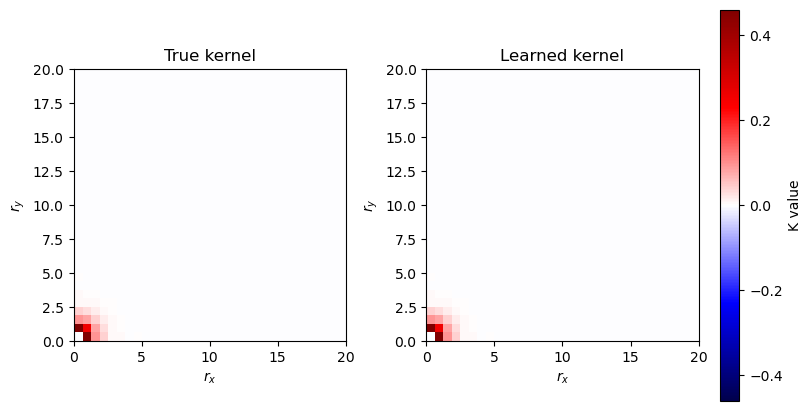

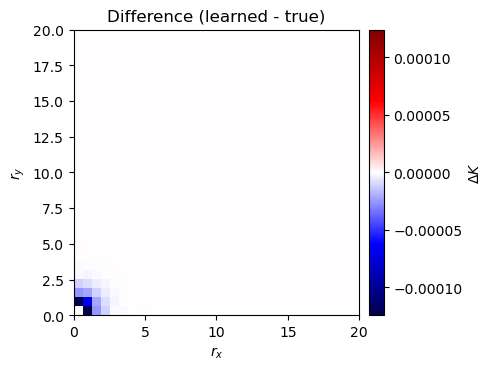

In [6]:
# 2D visualization of learned vs true kernel - real space
K_diff_np  = (k_full_np - K_true_np)

# symmetric color scale for fair comparison
R = 20
vmax = max(np.abs(K_true_np).max(), np.abs(k_full_np).max())
vmax_diff = np.abs(K_diff_np).max()
extent = [0, R, 0, R]

fig, axes = plt.subplots(
    1, 2,
    figsize=(8, 4),
    constrained_layout=True  # lets matplotlib handle spacing nicely
)

# --- True kernel ---
im0 = axes[0].imshow(
    K_true_np,
    origin="lower",
    extent=extent,
    vmin=-vmax, vmax=vmax,
    cmap="seismic"
)
axes[0].set_title("True kernel")
axes[0].set_xlabel(r"$r_x$")
axes[0].set_ylabel(r"$r_y$")

# --- Learned kernel ---
im1 = axes[1].imshow(
    k_full,
    origin="lower",
    extent=extent,
    vmin=-vmax, vmax=vmax,
    cmap="seismic"
)
axes[1].set_title("Learned kernel")
axes[1].set_xlabel(r"$r_x$")
axes[1].set_ylabel(r"$r_y$")

cbar = fig.colorbar(
    im1,
    ax=axes,
    location="right",
    fraction=0.04,  # width
    pad=0.02         # distance from rightmost axes
)
cbar.set_label("K value")

plt.show()

fig, ax = plt.subplots(figsize=(4,4))

im = ax.imshow(
    K_diff_np,
    origin="lower",
    extent=extent,
    vmin=-np.abs(K_diff_np).max(),
    vmax= np.abs(K_diff_np).max(),
    cmap="seismic"
)
ax.set_title("Difference (learned - true)")
ax.set_xlabel(r"$r_x$")
ax.set_ylabel(r"$r_y$")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"$\Delta K$")

plt.show()

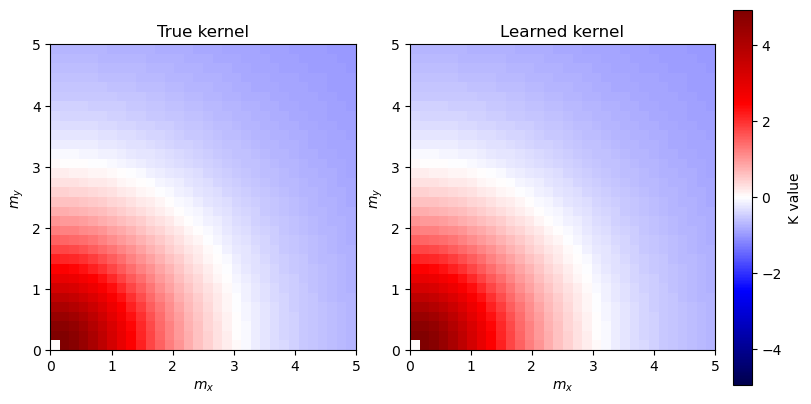

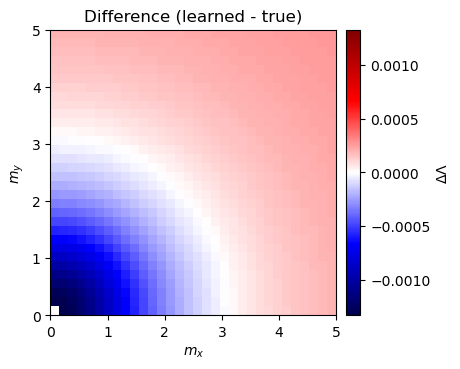

In [7]:
# 2D visualization of learned vs true kernel - momentum space
coords = torch.arange(0, N_x, device=device, dtype=dtype)  # [0, ..., N_x-1]
mx, my = torch.meshgrid(coords, coords, indexing="ij")      # (N_x, N_x)
m = torch.sqrt(mx**2 + my**2)                               # radial distance

Lam_true_np = lam_K_true.detach().cpu().numpy()
Lam_true_np[0, 0] = 0.0
lam_K_full_np = lam_K_full.detach().cpu().numpy()
lam_K_full_np[0, 0] = 0.0
Lam_diff_np  = (lam_K_full_np - Lam_true_np)

# symmetric color scale for fair comparison
M = 5
vmax = max(np.abs(Lam_true_np).max(), np.abs(lam_K_full_np).max())
vmax_diff = np.abs(Lam_diff_np).max()
extent = [0, M, 0, M]

fig, axes = plt.subplots(
    1, 2,
    figsize=(8, 4),
    constrained_layout=True  # lets matplotlib handle spacing nicely
)

# --- True kernel ---
im0 = axes[0].imshow(
    Lam_true_np,
    origin="lower",
    extent=extent,
    vmin=-vmax, vmax=vmax,
    cmap="seismic"
)
axes[0].set_title("True kernel")
axes[0].set_xlabel(r"$m_x$")
axes[0].set_ylabel(r"$m_y$")

# --- Learned kernel ---
im1 = axes[1].imshow(
    lam_K_full,
    origin="lower",
    extent=extent,
    vmin=-vmax, vmax=vmax,
    cmap="seismic"
)
axes[1].set_title("Learned kernel")
axes[1].set_xlabel(r"$m_x$")
axes[1].set_ylabel(r"$m_y$")

cbar = fig.colorbar(
    im1,
    ax=axes,
    location="right",
    fraction=0.04,  # width
    pad=0.02         # distance from rightmost axes
)
cbar.set_label("K value")

plt.show()

fig, ax = plt.subplots(figsize=(4,4))

im = ax.imshow(
    Lam_diff_np,
    origin="lower",
    extent=extent,
    vmin=-np.abs(Lam_diff_np).max(),
    vmax= np.abs(Lam_diff_np).max(),
    cmap="seismic"
)
ax.set_title("Difference (learned - true)")
ax.set_xlabel(r"$m_x$")
ax.set_ylabel(r"$m_y$")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"$\Delta \Lambda$")

plt.show()